In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import copy
from tqdm.notebook import tqdm

import time
import os

In [2]:
print(torch.__version__)
print(torch.cuda.is_available())

1.10.0
True


# Load CSV file and get labels

In [3]:
plt.ion()
csv_file = pd.read_csv('./Training_set_food.csv')

labels = list(dict.fromkeys(csv_file['label']))

# Data transformation and augmentation

In [4]:
#Data Transformation and Augmentation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# Dataset and DataLoaders

In [5]:
data_dir = '/homes/ncho/comp4211/data'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
test_datasets = datasets.ImageFolder(os.path.join(data_dir, 'test'), data_transforms['val'])

image_dataloader = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16, shuffle=True, num_workers=1) for x in ['train', 'val']}
test_dataloader = torch.utils.data.DataLoader(test_datasets, batch_size=1, shuffle=False, num_workers=1)

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('using device: {}'.format(device))

using device: cuda:0


# imshow function for tensor image

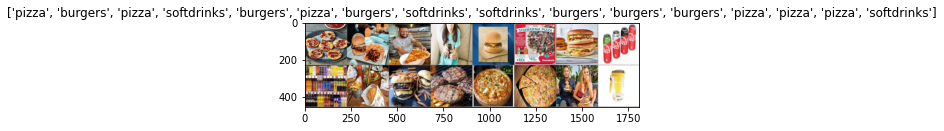

In [6]:
def imshow(imgs, title=None):
    #imshow for img(tensor)
    imgs = imgs.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    imgs = std * imgs + mean
    imgs = np.clip(imgs, 0, 1)
    plt.imshow(imgs)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

inputs, classes = next(iter(image_dataloader['train']))

imgs = torchvision.utils.make_grid(inputs)

imshow(imgs, title=[class_names[x] for x in classes])

# Train function and its pipeline

In [7]:
def train(model, criterion, optimizer, scheduler, num_epochs=30, early_stopping=True, save_name='CoAtNet'):
    last_loss = 100
    patience = 5
    trigger_times = 0

    total_start = time.time()

    total_train_accuracy = []
    total_train_loss = []
    total_val_accuracy = []
    total_val_loss = []

    best_model_weight = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = float('inf')

    for epoch in range(num_epochs):
        start = time.time()
        print('Epoch {} / {}'.format(epoch, num_epochs-1))
        print('-' * 20)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0

            #for inputs, labels in tqdm(image_dataloader[phase]):
            for index, (inputs, labels) in enumerate(image_dataloader[phase]):
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_accuracy = running_corrects.float() / dataset_sizes[phase]

            if phase == 'train':
                total_train_loss.append(epoch_loss)
                total_train_accuracy.append(epoch_accuracy)
            if phase == 'val':
                total_val_loss.append(epoch_loss)
                total_val_accuracy.append(epoch_accuracy)

            print('{} Loss: {:.5f} Accuracy: {:.5f}'.format(phase, epoch_loss, epoch_accuracy))

            if phase == 'val' and epoch_accuracy > best_acc:
                best_acc = epoch_accuracy
                best_loss = epoch_loss
                best_model_weight = copy.deepcopy(model.state_dict())

            if early_stopping and phase == 'val':
                if last_loss < epoch_loss:
                    trigger_times += 1
                    if trigger_times >= patience:
                        print('Early stopping at epoch {}'.format(epoch))
                        total_time_elapsed = np.round(time.time() - total_start, 3)
                        print('Completed training in {:0f}m {:03f}s'.format(total_time_elapsed // 60, total_time_elapsed % 60))
                        print('Best Accuracy: {}, Best Loss: {}'.format(best_acc, best_loss))
                        model.load_state_dict(best_model_weight)
                        return model, total_train_accuracy, total_train_loss, total_val_accuracy, total_val_loss
                else:
                    trigger_times = 0
                last_loss = epoch_loss
        
        #save on every 10 epochs
        if epoch % 10 == 0:
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                'epoch': epoch
            }, '/homes/ncho/comp4211/weights/{}_epoch_{}.pt'.format(save_name, epoch))

        end = np.round(time.time() - start, 3)
        print('Epoch {}: {}s\n'.format(epoch, end))

    total_time_elapsed = np.round(time.time() - total_start, 3)
    print('Completed training in {:0f}m {:03f}s'.format(total_time_elapsed // 60, total_time_elapsed % 60))
    print('Best Accuracy: {}, Best Loss: {}'.format(best_acc, best_loss))

    model.load_state_dict(best_model_weight)
    return model, total_train_accuracy, total_train_loss, total_val_accuracy, total_val_loss

# Visualize for validation set

In [8]:
def visualize_model(model, num_imgs=4):
    train_phase = model.training
    model.eval()
    total_images_processed = 0
    fig = plt.figure()

    with torch.no_grad():
        #for inputs, labels in tqdm(image_dataloader['val']):
        for index, (inputs, labels) in enumerate(image_dataloader['val']):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                total_images_processed += 1
                ax = plt.subplot(num_imgs//2, 2, total_images_processed)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if total_images_processed == num_imgs:
                    model.train(mode=train_phase)
                    return
        model.train(mode=train_phase)

# Network Structure

## Hyperparameter Search

In [ ]:
from random import randint, choices
import random
from datetime import datetime
from math import log2
from coatnet import CoAtNet

params = {
    'channels': [[32, 64, 128, 64, 32], [64, 128, 256, 128, 64], [128, 256, 512, 256, 128], [256, 512, 1024, 512, 256], [16, 32, 64, 128, 256], [32, 64, 128, 256, 512], [64, 128, 256, 512, 1024]],
    'block_types': [['C', 'C', 'C', 'C'], ['C', 'C', 'C', 'T'], ['C', 'C', 'T', 'T']],
    'lr': [0.01, 0.05, 0.001, 0.005]
}

hyper_search = 10
search_acc = 0
best_params = ''
for i in range(hyper_search):
    random.seed(datetime.now())
    rand_channels = randint(0, 6)
    rand_channels_values =  params['channels'][rand_channels]
    rand_block_type = randint(0, 2)
    rand_lr = randint(0, 3)
    rand_block = [int(log2(i)) for i in rand_channels_values]
    for i in range(len(rand_block)):                            #make sure 1st, 2nd and 5th entries are 2
        if i == 0 or i == 1 or i == len(rand_block)-1:
            rand_block[i] = 2
        else:
            if rand_block[i] % 2 == 1:                          #make sure the number is even
                rand_block[i] += 1
    
    model = CoAtNet((224, 224), 3, num_blocks=rand_block, channels=params['channels'][rand_channels], block_types=params['block_types'][rand_block_type], num_classes=3)
    optimizer = optim.SGD(model.fc.parameters(), lr=params['lr'][rand_lr], momentum=0.9)
    model = model.to(device)
    learning_rate_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
    criterion = nn.CrossEntropyLoss()

    current_parameters = {
        'lr': params['lr'][rand_lr],
        'channels': params['channels'][rand_channels],
        'block_type': params['block_types'][rand_block_type],
        'rand_block': rand_block
    }

    print('Current parameters:', current_parameters)
    model, total_train_accuracy, total_train_loss, total_val_accuracy, total_val_loss = train(model, criterion, optimizer, learning_rate_scheduler, num_epochs=20)

    max_acc = max(total_val_accuracy)
    max_acc_idx = total_val_accuracy.index(max_acc)
    min_loss = total_val_loss[max_acc_idx]
    
    print('max accuracy: {} min loss: {}'.format(max_acc, min_loss))

    if max_acc > search_acc:
        best_params = current_parameters
        search_acc = max_acc
    model = model.cpu()
print(best_params)

# Train

## CoAtNet0

/homes/ncho/miniconda3/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272068185/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch 0 / 499
--------------------
train Loss: 1.36904 Accuracy: 0.58122
val Loss: 1.10377 Accuracy: 0.64352
Epoch 0: 64.285s

Epoch 1 / 499
--------------------
train Loss: 1.22583 Accuracy: 0.63598
val Loss: 0.81085 Accuracy: 0.72593
Epoch 1: 40.495s

Epoch 2 / 499
--------------------
train Loss: 1.11413 Accuracy: 0.67407
val Loss: 1.45312 Accuracy: 0.63796
Epoch 2: 45.554s

Epoch 3 / 499
--------------------
train Loss: 0.92333 Accuracy: 0.69577
val Loss: 1.43921 Accuracy: 0.58704
Epoch 3: 43.609s

Epoch 4 / 499
--------------------
train Loss: 1.16911 Accuracy: 0.67328
val Loss: 0.69116 Accuracy: 0.76574
Epoch 4: 45.234s

Epoch 5 / 499
--------------------
train Loss: 1.22242 Accuracy: 0.67646
val Loss: 2.68682 Accuracy: 0.53796
Epoch 5: 43.603s

Epoch 6 / 499
--------------------
train Loss: 1.00825 Accuracy: 0.70053
val Loss: 1.08568 Accuracy: 0.68519
Epoch 6: 43.111s

Epoch 7 / 499
--------------------
train Loss: 0.97244 Accuracy: 0.69868
val Loss: 1.31759 Accuracy: 0.61574
Ep

<Figure size 432x288 with 0 Axes>

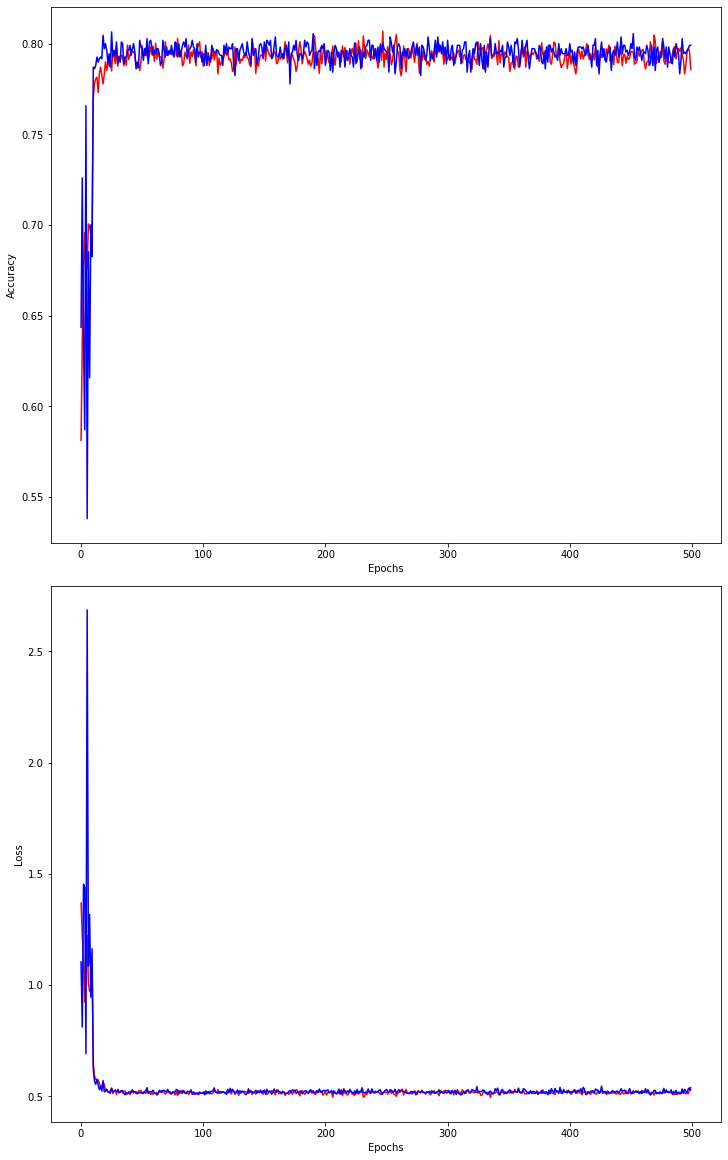

In [9]:
from coatnet import coatnet_0

#model.cpu()

model = coatnet_0()
optimizer = optim.SGD(model.fc.parameters(), lr=0.005, momentum=0.9)
learning_rate_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
criterion = nn.CrossEntropyLoss()
model = model.to(device)
model, total_train_accuracy, total_train_loss, total_val_accuracy, total_val_loss = train(model, criterion, optimizer, \
    learning_rate_scheduler, num_epochs=500, early_stopping=True, save_name='CoAtNet0')

#Graph for accuracy and loss
plt.clf()
fig, axs = plt.subplots(2, 1, figsize=(10, 16), constrained_layout=True)

total_train_accuracy = torch.Tensor(total_train_accuracy).cpu()
total_val_accuracy = torch.Tensor(total_val_accuracy).cpu()
total_train_loss = torch.Tensor(total_train_loss).cpu()
total_val_loss = torch.Tensor(total_val_loss).cpu()

axs[0].plot(total_train_accuracy, 'r-', label='train accuracy')
axs[0].plot(total_val_accuracy, 'b-', label='val accuracy')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')

axs[1].plot(total_train_loss, 'r-', label='train loss')
axs[1].plot(total_val_loss, 'b-', label='val loss')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')

plt.show()


## Visualize some validation set prediction results

<Figure size 432x288 with 0 Axes>

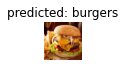

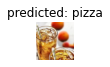

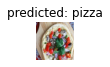

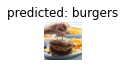

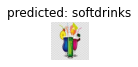

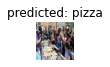

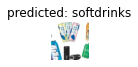

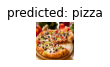

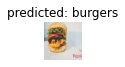

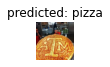

In [10]:
plt.clf()
visualize_model(model, num_imgs=10)

plt.ioff()
plt.show()

## Save CoAtNet0 final model weights

In [11]:
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': criterion
}, '/homes/ncho/comp4211/weights/CoAtNet0_final.pt')

## CoAtNet with hyperparameter search

In [12]:
#Load CoAtNet
from coatnet import CoAtNet

#best parameters: {'lr': 0.005, 'channels': [16, 32, 64, 128, 256], 'block_type': ['C', 'C', 'T', 'T'], 'rand_block': [2, 2, 6, 8, 2]}

model.cpu()

num_blocks = [2, 2, 6, 8, 2]
channels = [16, 32, 64, 128, 256]
block_types = ['C', 'C', 'T', 'T']
model = CoAtNet((224, 224), 3, num_blocks=num_blocks, channels=channels, block_types=block_types, num_classes=3)

optimizer = optim.SGD(model.fc.parameters(), lr=0.005, momentum=0.9)
learning_rate_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
criterion = nn.CrossEntropyLoss()
model = model.to(device)

## Train and plot accuracy and loss graph

Epoch 0 / 499
--------------------
train Loss: 1.25999 Accuracy: 0.54365
val Loss: 0.85066 Accuracy: 0.65370
Epoch 0: 43.844s

Epoch 1 / 499
--------------------
train Loss: 1.13078 Accuracy: 0.59365
val Loss: 1.12616 Accuracy: 0.58333
Epoch 1: 39.06s

Epoch 2 / 499
--------------------
train Loss: 1.05787 Accuracy: 0.61772
val Loss: 0.75017 Accuracy: 0.71204
Epoch 2: 40.902s

Epoch 3 / 499
--------------------
train Loss: 0.98745 Accuracy: 0.63598
val Loss: 1.05612 Accuracy: 0.63241
Epoch 3: 43.703s

Epoch 4 / 499
--------------------
train Loss: 1.12198 Accuracy: 0.61931
val Loss: 0.74136 Accuracy: 0.72222
Epoch 4: 45.96s

Epoch 5 / 499
--------------------
train Loss: 0.93930 Accuracy: 0.65873
val Loss: 0.77731 Accuracy: 0.70093
Epoch 5: 45.2s

Epoch 6 / 499
--------------------
train Loss: 0.92952 Accuracy: 0.66058
val Loss: 0.80585 Accuracy: 0.70093
Epoch 6: 40.603s

Epoch 7 / 499
--------------------
train Loss: 0.83708 Accuracy: 0.68069
val Loss: 0.77677 Accuracy: 0.69815
Epoch 

<Figure size 432x288 with 0 Axes>

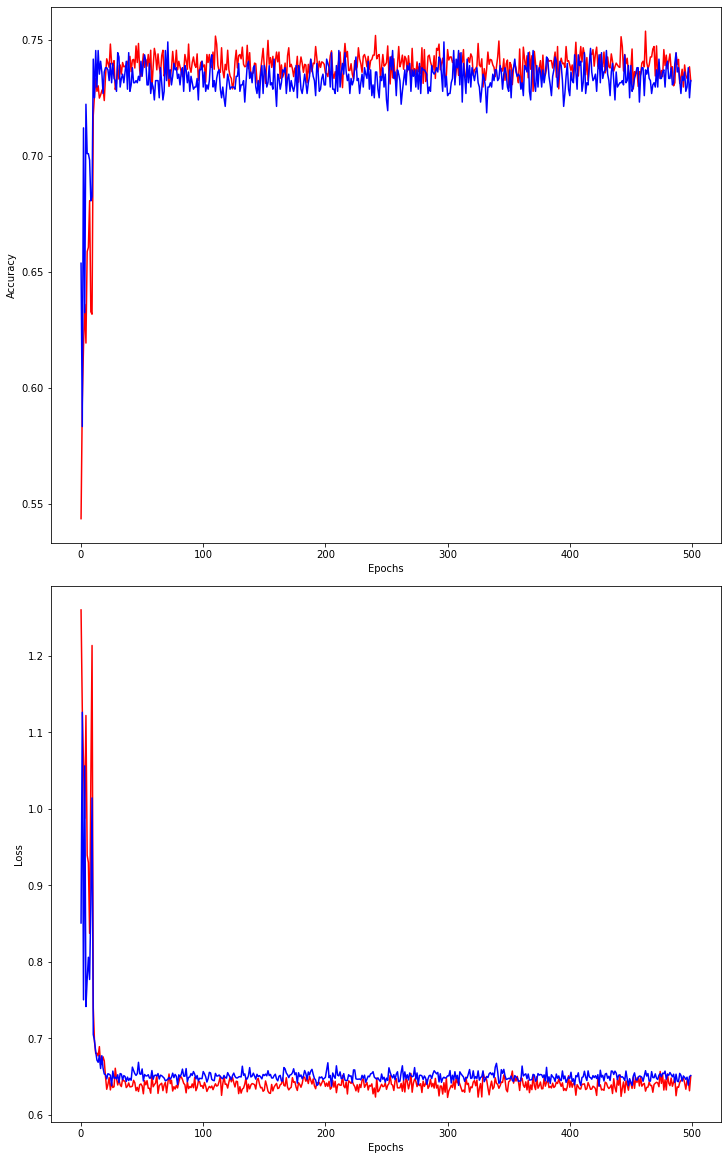

In [13]:
model, total_train_accuracy, total_train_loss, total_val_accuracy, total_val_loss = train(model, criterion, optimizer, \
    learning_rate_scheduler, num_epochs=500, early_stopping=True, save_name='CoAtNet_hp_search')

plt.clf()
fig, axs = plt.subplots(2, 1, figsize=(10, 16), constrained_layout=True)

total_train_accuracy = torch.Tensor(total_train_accuracy).cpu()
total_val_accuracy = torch.Tensor(total_val_accuracy).cpu()
total_train_loss = torch.Tensor(total_train_loss).cpu()
total_val_loss = torch.Tensor(total_val_loss).cpu()

axs[0].plot(total_train_accuracy, 'r-', label='train accuracy')
axs[0].plot(total_val_accuracy, 'b-', label='val accuracy')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')

axs[1].plot(total_train_loss, 'r-', label='train loss')
axs[1].plot(total_val_loss, 'b-', label='val loss')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')

plt.show()

## Visualize some validation set prediction results

<Figure size 432x288 with 0 Axes>

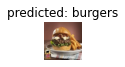

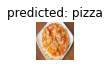

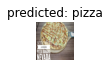

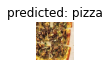

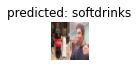

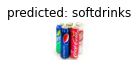

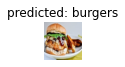

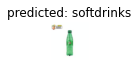

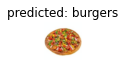

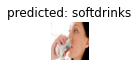

In [14]:
plt.clf()
visualize_model(model, num_imgs=10)

plt.ioff()
plt.show()

## Save final model

In [15]:
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': criterion
}, '/homes/ncho/comp4211/weights/CoAtNet_hp_search_final.pt')